# Transformed Gaussian Random Fields
## A demonstration notebook

This notebook demonstrates the models presented in: 
> J.-B. Courbot and B. Colicchio, "Transformed Gaussian Random Fields for Unsupervised Image Deconvolution," in *IEEE Signal Processing Letters*, vol. 29, pp. 2702-2706, 2022, doi:10.1109/LSP.2022.3233003.

The goal of these models is to provide a deconvolution framework with various priors: Gaussian Markov Random Fields and Transformed Gaussian Random Fields as well.
For comparison, a framework based on Total Variation (TV_1 and TV_2) is also provided. For details on this, please refer to:

> J.-B. Courbot and B. Colicchio, "A fast homotopy algorithm for gridless sparse recovery," in *Inverse Problems*, vol. 37, no. 2, pp. 025002, 2021, doi:10.1088/1361-6420/abd29c.


## 1. Imports and function definitions

In [1]:
import numpy as np 

# Display config
import matplotlib.pyplot as plt
from matplotlib import  rc
plt.rcParams['image.cmap'] = 'Spectral_r'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.origin'] = 'lower'

# Homemade code - TGRF
import Gaussian_MRF as gmrf
import unified_functions as uf
import unified_algo as ua
import Parameters as p
# Total-Variation based homotopy methods
import hom_TV as htv

%load_ext autoreload
%autoreload 2

In [38]:

def calc_RRMSE(X, X_est):
    """
    Calculate the Relative Root Mean Square Error (RRMSE) between two arrays.

    Parameters:
        X (ndarray): Original array.
        X_est (ndarray): Estimated or reconstructed array.

    Returns:
        float: RRMSE value.

    Raises:
        ValueError: If the shapes of X and X_est do not match.

    """
    if X.shape != X_est.shape:
        raise ValueError("Shapes of X and X_est do not match.")

    # Calculate the mean squared error (MSE)
    squared_error = (X - X_est) ** 2
    MSE = squared_error.sum()

    # Calculate the RRMSE
    RRMSE = np.sqrt(MSE / (X ** 2).sum())

    return RRMSE

def unite_names(phi, corr):
    """
    Proxy function to link names of phi(x) and the correlation function to names recognized by the lower functions.

    Parameters:
        phi (str): Name of the phi(x) function.
        corr (str): Name of the correlation function.

    Returns:
        str: Unified name recognized by the lower-level functions.

    """
    if phi == 'id':
        name = 'single'
    elif phi == 'sigmoid':
        name = 'logit'
    elif phi == 'exp':
        name = 'lognorm'

    if corr == 'exp':
        name = name + '_exp'

    return name

def display2(A,B,titles):
    plt.figure(figsize=(6.5,2.5))
    plt.subplot(121)    
    plt.imshow(A);plt.colorbar();plt.axis('off')
    plt.title(titles[0])

    plt.subplot(122)
    plt.imshow(B) ;plt.colorbar();plt.axis('off')
    plt.title(titles[1])
    plt.tight_layout()
    
def display3(A,B,C,titles):
    plt.figure(figsize=(9.75,2.5))
    plt.subplot(131)    
    plt.imshow(A);plt.colorbar();plt.axis('off')
    plt.title(titles[0])
    
    plt.subplot(132)
    plt.imshow(B) ;plt.colorbar();plt.axis('off')
    plt.title(titles[1])
    
    plt.subplot(133)
    plt.imshow(C) ;plt.colorbar();plt.axis('off')
    plt.title(titles[2])
    plt.tight_layout()

# 1. Sampling 

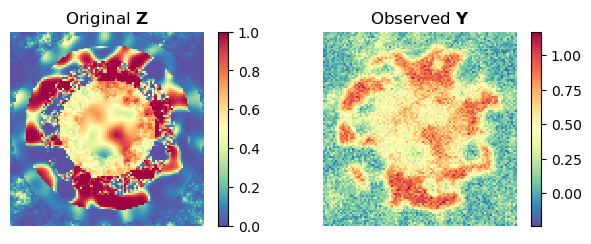

In [42]:
# image dimension
lx,ly = 100,100
simulation = 'onion' # 'vanilla' for a pure simulation or 'onion' for a more complicated image

# Signal to Noise Ratio (in dB)
SNR = 15
# Airy scale a.k.a. typical size of the PSF (in pixels)
airy_scale = 1
# Random seed to replicate results
seed = 1234

if simulation == 'vanilla':
    phi = 'id'           # 'id' or 'sigmoid' or 'exp'
    corr = 'gau'         # 'exp' or 'gau'
    sampling_model = unite_names(phi,corr)
    
    X,Y,a_base,Theta_true = ua.simul_XY(seed,airy_scale,SNR,sigma_GMRF=1,simul_model=sampling_model,lx=lx,ly=ly)
    Xi = uf.form_Xi(X,sampling_model,Theta_true) 
    
elif simulation=='onion':
    Xi,Y,a_base,= ua.simul_XY_onion(seed,airy_scale,SNR)
    
display2(Xi,Y,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$'))

# 2. Inferences 

## 2.1 Gaussian Markov Random Fields

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 0.80 seconds.
> RRMSE = 0.2932


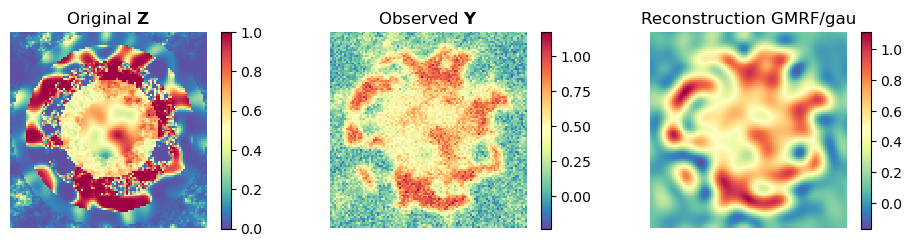

In [43]:
inference_phi = 'id'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'gau'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_GMRF_gau,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_GMRF_gau))
display3(Xi,Y,X_GMRF_gau,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Reconstruction GMRF/gau'))

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 0.78 seconds.
> RRMSE = 0.2248


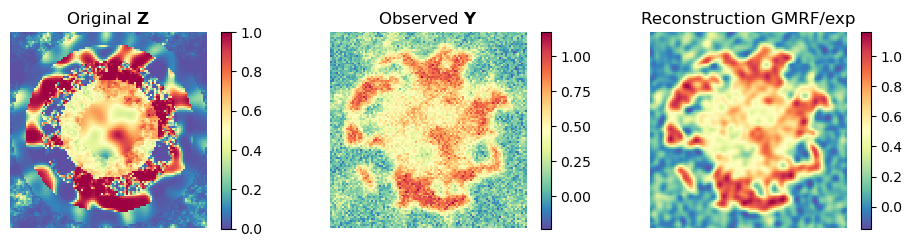

In [44]:
inference_phi = 'id'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'exp'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_GMRF_exp,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_GMRF_exp))
display3(Xi,Y,X_GMRF_exp,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Reconstruction GMRF/exp'))

## 2.2 Transformed GRF variations 

These may take some time on a standard computer, there is time for a coffee ☕.

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 172.36 seconds.
     ParHMC: running batch no. 9...
     ParHMC: burn-in finished before Batch 9: time to break
               - Computation time: 1563.2343
> RRMSE = 0.2250


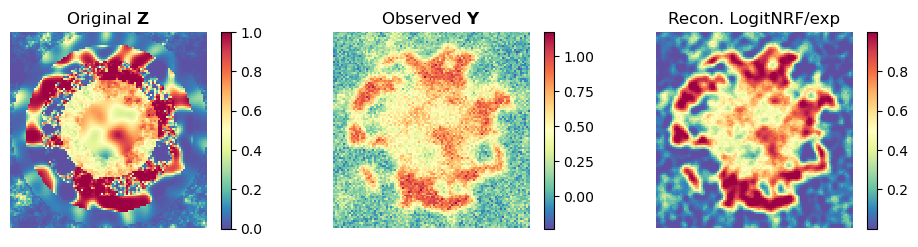

In [46]:
inference_phi = 'sigmoid'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'exp'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_logit_exp,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_logit_exp))
display3(Xi,Y,X_logit_exp,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. LogitNRF/exp'))

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 7.07 seconds.
     ParHMC: running batch no. 8...
     ParHMC: burn-in finished before Batch 8: time to break
               - Computation time: 68.7738
> RRMSE = 0.2928


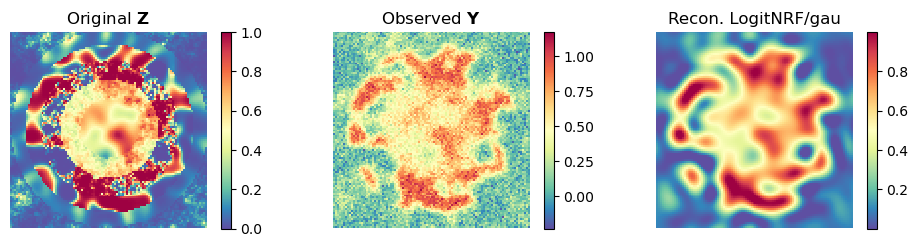

In [51]:
inference_phi = 'sigmoid'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'gau'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_logit_gau,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_logit_gau))
display3(Xi,Y,X_logit_gau,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. LogitNRF/gau'))

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 196.42 seconds.
     ParHMC: running batch no. 7...
     ParHMC: burn-in finished before Batch 7: time to break
               - Computation time: 1166.9883
> RRMSE = 0.2228


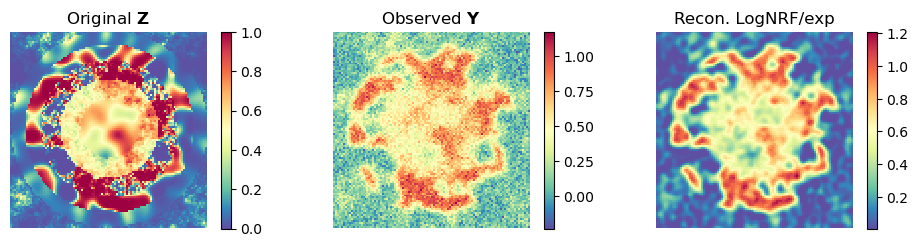

In [52]:
inference_phi = 'exp'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'exp'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_lognrf_exp,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_lognrf_exp))
display3(Xi,Y,X_lognrf_exp,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. LogNRF/exp'))

  SEM : iteration 11...
  SEM stops at iteration 11 - elapsed = 10.22 seconds.
     ParHMC: running batch no. 8...
     ParHMC: burn-in finished before Batch 8: time to break
               - Computation time: 63.2507
> RRMSE = 0.2928


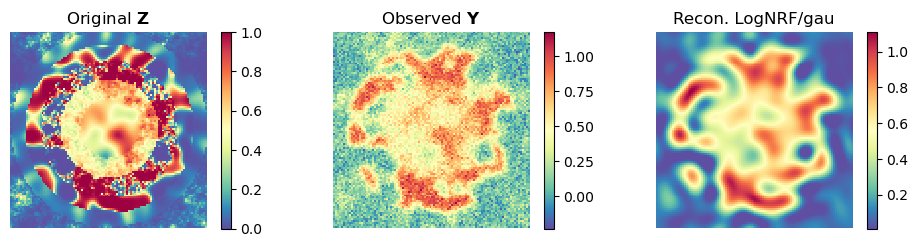

In [53]:
inference_phi = 'exp'           # 'id' or 'sigmoid' or 'exp'
inference_corr = 'gau'         # 'exp' or 'gau'
inference_model = unite_names(inference_phi,inference_corr)

X_lognrf_gau,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_lognrf_gau))
display3(Xi,Y,X_lognrf_gau,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. LogNRF/gau'))

## 2.3 Total Variation 

###### Entering the homotopy algorithm with target std=0.211543
######
Simple homotopy search found lamda = 0.5000 and the corresponding diracs in 2 steps
Elapsed time: 1.23
> RRMSE = 0.3812


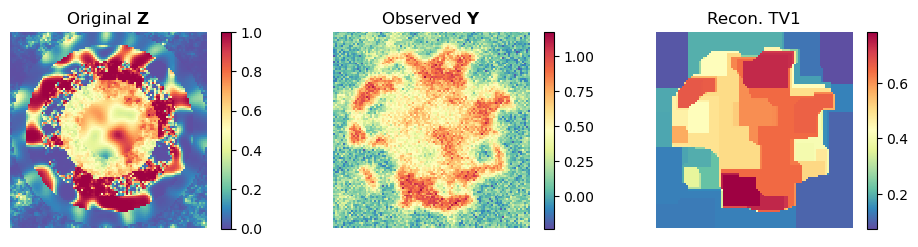

In [57]:
X_TV1 = htv.run_tv(Y,a_base,Theta_true.sig_noise*1.05,solver='TV1',verbose=False)
# Note : Theta_true.sig_noise*1.05 serves as a target STD of the residual.
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_TV1))
display3(Xi,Y,X_TV1,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. TV1'))

###### Entering the homotopy algorithm with target std=0.211543
######
Simple homotopy search found lamda = 1.0000 and the corresponding diracs in 1 steps
Elapsed time: 0.95
> RRMSE = 0.3030


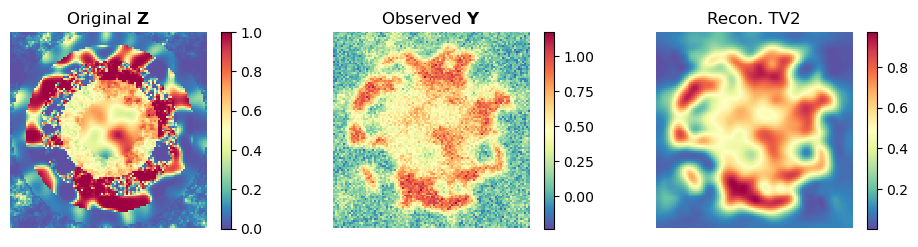

In [58]:
X_TV2 = htv.run_tv(Y,a_base,Theta_true.sig_noise*1.05,solver='TV2',verbose=False)
# Note : Theta_true.sig_noise*1.05 serves as a target STD of the residual.
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_TV2))
display3(Xi,Y,X_TV2,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. TV2'))

## 2.4 Cauchy MRF
The implementation is similar to the other models, and the model was originally presented in :
> Suuronen, J., Chada, N. K., & Roininen, L. (2022). Cauchy Markov random field priors for Bayesian inversion. Statistics and Computing, 32(2), 33.

  SEM : iteration 12...
  SEM stops at iteration 12 - elapsed = 7.26 seconds.
     ParHMC: running batch no. 11...
     ParHMC: burn-in finished before Batch 11: time to break
               - Computation time: 96.3124
> RRMSE = 0.2822


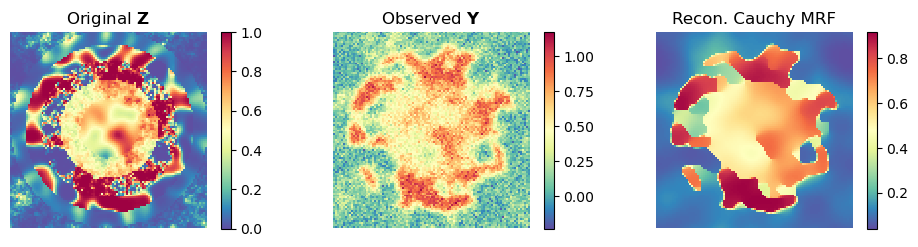

In [59]:
inference_model = 'cauchy'

X_cauchy,_ = ua.run_exp(Y,a_base,inference_model,EM=False,verbose=True)
print("> RRMSE = %.4f"%calc_RRMSE(Xi,X_cauchy))
display3(Xi,Y,X_cauchy,('Original $\mathbf{Z}$','Observed $\mathbf{Y}$','Recon. Cauchy MRF'))

# 3. Overview of results  

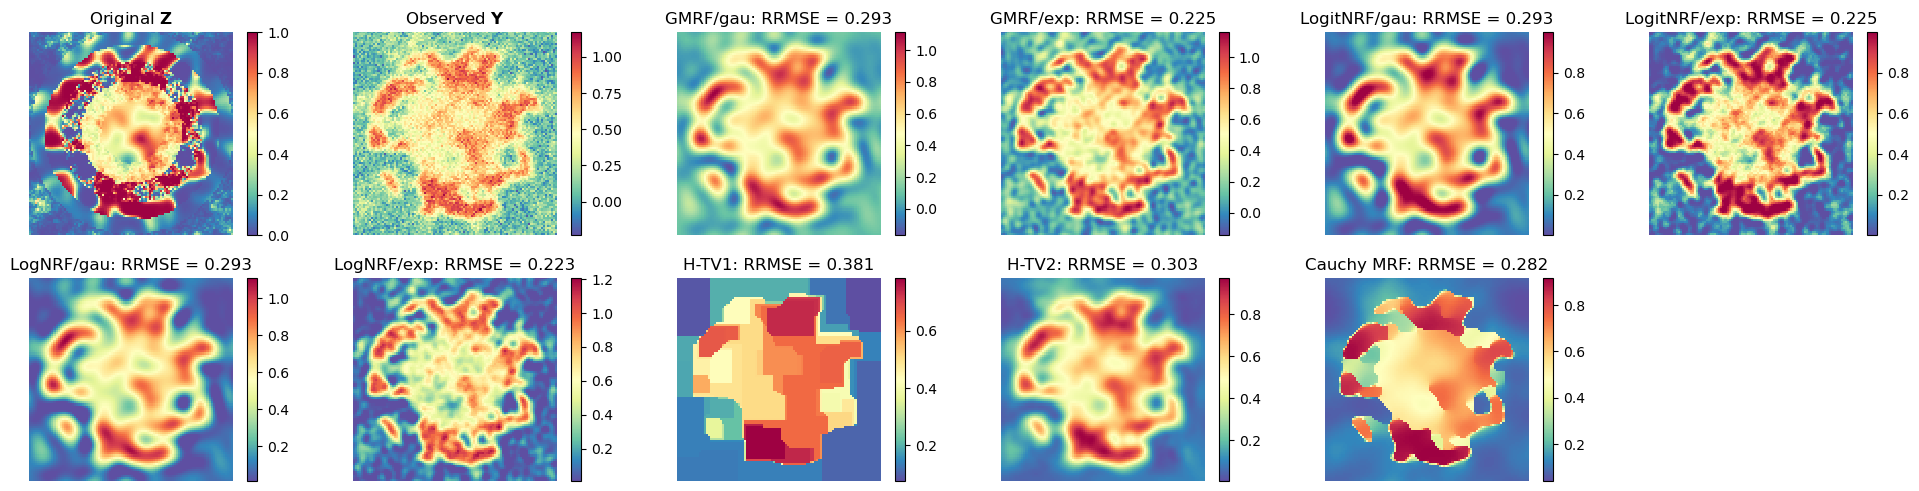

In [76]:
list_of_results = (X_GMRF_gau,X_GMRF_exp,X_logit_gau,X_logit_exp,X_lognrf_gau,X_lognrf_exp,X_TV1,X_TV2,X_cauchy)
list_of_names = ('GMRF/gau','GMRF/exp', 'LogitNRF/gau', 'LogitNRF/exp', 'LogNRF/gau','LogNRF/exp','H-TV1','H-TV2', 'Cauchy MRF')
list_of_RRMSE=  [calc_RRMSE(Xi,X_prop) for X_prop in list_of_results]

n_col = 6#2+len(list_of_results)
n_lin = 2

plt.figure(figsize=(3.25*n_col,5))
plt.subplot(n_lin,n_col,1);
plt.imshow(Xi);plt.axis('off');plt.colorbar(); plt.title('Original $\mathbf{Z}$')
plt.subplot(n_lin,n_col,2);
plt.imshow(Y);plt.axis('off');plt.colorbar(); plt.title('Observed $\mathbf{Y}$')

for i in range(3,3+len(list_of_results)):
    plt.subplot(n_lin,n_col,i)
    plt.imshow(list_of_results[i-3]);plt.axis('off');plt.colorbar(); 
    title = list_of_names[i-3] + ': RRMSE = %.3f'%list_of_RRMSE[i-3]
    plt.title(title)
plt.tight_layout()